Welcome to my notebook

# ======================== IMPORT & CONNECTION ========================

In [40]:
import pandas as pd
from trino import dbapi
from trino.auth import BasicAuthentication
from sqlalchemy import create_engine
from sqlalchemy.exc import SQLAlchemyError # 引入异常处理
from urllib.parse import quote_plus
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
import numpy as np


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 1000)


In [4]:
DB_HOST = 'rm-bp1o6283vw74wr4x5.mysql.rds.aliyuncs.com'
DB_PORT = 3306
DB_USER = 'on_ds_test' 
DB_PASS = quote_plus('HC73aA7aeLxJFLFH_@bPeHkv')
DB_NAME = 'on_ds_test'

DATABASE_URL = f"mysql+pymysql://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/{DB_NAME}?charset=utf8mb4"

try:
    engine = create_engine(DATABASE_URL)
    print("✅ 数据库连接引擎创建成功。")
except Exception as e:
    print(f"❌ 数据库连接失败: {e}")
    sys.exit()


✅ 数据库连接引擎创建成功。


# ========================== DIGITAL BEHAVIOR ==========================

## ========= READ PRODUCT TABLE ========

In [5]:
# ===================== PRODUCT ===================== #

PRODUCT_MYSQL = 'dim_product_colors_info'
try:
    product = pd.read_sql_table(
        table_name=PRODUCT_MYSQL,
        con=engine
    )

    print(f"\n✅ 成功加载表 '{PRODUCT_MYSQL}'，共 {len(product)} 行。")
    print("\nDataFrame 头部数据:")
    display(product.head()) 

except Exception as e:
    print(f"❌ 加载表时出错: {e}")


✅ 成功加载表 'dim_product_colors_info'，共 7081 行。

DataFrame 头部数据:


,product_id(style),available from,color,gender,shoes_gender,product name,price,model,category,community,style_conditions,terrain,scene_cn,season,picture,style_bottoms,style_tops,vertical,style_sku
0,101.00001,2019-02-14,Navy,mens,mens,Comfort-T Navy M SS19,490.0,Comfort-T,Apparel,Tops and t-shirts,warm,,None,None,https://oss.on-running.cn/contentful_dtc/149f4...,None,Short sleeves,Performance All Day,101CMFRT
1,101.00002,2019-02-14,Grape,mens,mens,Comfort-T Grape M SS19,490.0,Comfort-T,Apparel,Tops and t-shirts,warm,,None,None,https://oss.on-running.cn/contentful_dtc/16b79...,None,Short sleeves,Performance All Day,101CMFRT
2,101.00039,2019-08-13,Camel,mens,mens,Comfort-T Camel M FW19,490.0,Comfort-T,Apparel,Tops and t-shirts,warm,,None,None,https://oss.on-running.cn/contentful_dtc/0281d...,None,Short sleeves,Performance All Day,101CMFRT
3,101.00090,2021-10-04,Olive,mens,mens,On-T Olive M,490.0,On-T,Apparel,Tops and t-shirts,None,,"综训,日常","[""spring"",""summer"",""Autumn"",""Winter""]",https://oss.on-running.cn/contentful_dtc/37bd2...,None,Short sleeves,Performance All Day,101
4,101.00143,2020-02-18,Grey,mens,mens,On-T Grey M SS20,490.0,On-T,Apparel,Tops and t-shirts,None,,"综训,日常","[""spring"",""summer"",""Autumn"",""Winter""]",https://oss.on-running.cn/contentful_dtc/5b016...,None,Short sleeves,Performance All Day,101


## ======== READ TRACKING DATA ========

In [6]:
CURRENT_DATE = pd.to_datetime(datetime.now().date()) # 实际应用中可以使用当前系统日期
CURRENT_DATE_SQL = f"'{CURRENT_DATE.strftime('%Y-%m-%d')}'"
R6M_DATE = CURRENT_DATE - pd.DateOffset(months=6)
R6M_DATE_SQL = f"'{R6M_DATE.strftime('%Y-%m-%d')}'"

# 配置Trino连接
conn = dbapi.connect(
    host='192.168.0.163',
    port=8082,
    user='ta',
    # auth=BasicAuthentication("your-username", "your-password"),
    catalog='hive',  # 根据你的Trino配置指定catalog
    schema='ta'
)

# 执行查询
query = f'''SELECT 
"#event_name" as event_name,
"#event_time" as event_time,
"#account_id" as account_id,
"page_type",
"#os" as os,
"login_pt",
"#mp_platform" as mp_platform,
"current_status",
"product_name", --加购 & PDP
"product_type", --加购 & PDP
"search_term", --搜索
"product_id" -- PDP
FROM v_event_3
where "#account_id" is not null 
and "#event_time" > date({R6M_DATE_SQL}) and "#event_time" < date({CURRENT_DATE_SQL})
and "#event_name" in ('add_to_cart','pdp_view','plp_category_navi_click','search')
'''
event = pd.read_sql(query, conn)


print(event.head())
print(event.shape)
print(event.describe())
print(event.dtypes)


# "to_page_type", --运营位点击
# "item_rank",--运营位点击
# "to_page_path", --运营位点击
# "component_type",--运营位点击
# "module_rank",--运营位点击
# "component_name",--运营位点击
# "item_name",--运营位点击
# "module_name" --运营位点击
# 'MktClick'
# "cat_level", --点击品类
# "cat_list", --点击品类
# "click_type", --点击品类
# "cat_name" --点击品类
# "channel", --广告归因
# "if_employee",
# "page_cat1", 
# "page_cat2",
# "page_cat3",
# "refer_page_type",
# "current_page_path",
# "#province" as province,
# "#city" as city,

/tmp/ipykernel_608/3651439163.py:35: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  event = pd.read_sql(query, conn)


    event_name              event_time                            account_id page_type   os login_pt mp_platform current_status         product_name product_type search_term product_id
0  add_to_cart 2025-08-31 03:57:32.010  c163d6c5-5b29-47cc-8449-44bdc0689b17       pdp  iOS      小程序      wechat           登录用户           Core Pants      Apparel        None       None
1  add_to_cart 2025-08-31 03:03:57.340  68774fec-cbbb-4042-9501-1521090cb817       pdp  iOS      小程序      wechat           登录用户          Track Pants      Apparel        None       None
2  add_to_cart 2025-08-31 04:00:58.200  be82c434-8439-41e8-8831-5616f5fa5bc9       pdp  iOS      小程序      wechat           登录用户      THE ROGER Pro 2        Shoes        None       None
3  add_to_cart 2025-08-31 03:57:29.047  c163d6c5-5b29-47cc-8449-44bdc0689b17       pdp  iOS      小程序      wechat           登录用户           Core Pants      Apparel        None       None
4  add_to_cart 2025-08-31 05:50:46.128  a037712b-1b98-4297-8676-fb065aad9cf

## ======= PDP & ATC =======

In [171]:
event['event_time'] = pd.to_datetime(event['event_time'])

# 步骤 2: 合并产品类别信息
merged_df = event.merge(
    product[['model', 'vertical']],
    left_on='product_name',
    right_on='model',
    how='left'
)

mapping_dict = {
    'Performance All Day': 'allday',
    'PAD': 'allday',
    'Performance Running': 'running',
    'PR': 'running',
    'Performance Training ': 'training',
    'PTR': 'training',
    'Performance Outdoor': 'outdoor',
    'PO': 'outdoor',
    'Performance Tennis': 'tennis',
    'PT': 'tennis'
}

merged_df['vertical'] = merged_df['vertical'].replace(mapping_dict)

merged_df = merged_df[merged_df['vertical'].isin(['allday','running','training','outdoor','tennis'])]

# 检查是否有未匹配的产品（如果出现NaN，可能需要清洗或补充产品信息表）
if merged_df['vertical'].isnull().any():
    print("⚠️ 警告: 存在未能匹配到产品类别的记录。")
    merged_df.dropna(subset=['vertical'], inplace=True)

print("--- 合并后的数据 (merged_df) ---")
print(merged_df.head())
print("-" * 40)

--- 合并后的数据 (merged_df) ---
    event_name              event_time                            account_id page_type   os login_pt mp_platform current_status product_name product_type search_term product_id       model vertical
0  add_to_cart 2025-08-31 03:57:32.010  c163d6c5-5b29-47cc-8449-44bdc0689b17       pdp  iOS      小程序      wechat           登录用户   Core Pants      Apparel        None       None  Core Pants  running
1  add_to_cart 2025-08-31 03:57:32.010  c163d6c5-5b29-47cc-8449-44bdc0689b17       pdp  iOS      小程序      wechat           登录用户   Core Pants      Apparel        None       None  Core Pants  running
2  add_to_cart 2025-08-31 03:57:32.010  c163d6c5-5b29-47cc-8449-44bdc0689b17       pdp  iOS      小程序      wechat           登录用户   Core Pants      Apparel        None       None  Core Pants  running
3  add_to_cart 2025-08-31 03:57:32.010  c163d6c5-5b29-47cc-8449-44bdc0689b17       pdp  iOS      小程序      wechat           登录用户   Core Pants      Apparel        None       None  Cor

In [172]:

# 定义要分别计算的事件名称
EVENT_PDP_VIEW = 'pdp_view'
EVENT_ADD_TO_CART = 'add_to_cart'
BASE_COLUMNS = ['account_id', 'vertical'] # 保持这两个列为计算分组键


# --- 步骤 2: 定义计算函数 (无变化) ---

def calculate_affinity_metrics(df, event_name, prefix):
    """
    计算特定事件的 6 个月次数和距今天数，按 account_id 和 product_category 分组。
    """

    event_df = df[df['event_name'] == event_name].copy()
    if event_df.empty:
        return None

    # A. 计算过去六个月的次数 (6M_Count)
    count_result = event_df.groupby(
        BASE_COLUMNS
    ).size().reset_index(name=f'{prefix}6M_Count')

    # B. 计算最近一次距今的天数 (Days_Since_Last)
    latest_time_result = event_df.groupby(
        BASE_COLUMNS
    )['event_time'].max().reset_index(name='Latest_Action_Time')

    latest_time_result[f'{prefix}Days_Since_Last'] = (
        CURRENT_DATE - latest_time_result['Latest_Action_Time']
    ).dt.days

    # 合并次数和天数结果
    final_metrics = pd.merge(
        count_result,
        latest_time_result.drop(columns=['Latest_Action_Time']),
        on=BASE_COLUMNS,
        how='outer'
    )
    return final_metrics




In [173]:
# --- 步骤 3: 分别计算 PDP Click 和 Add to Cart 并合并中间结果 ---

pdp_result = calculate_affinity_metrics(merged_df, EVENT_PDP_VIEW, 'PDP_View_')
atc_result = calculate_affinity_metrics(merged_df, EVENT_ADD_TO_CART, 'ATC_')



# 将 PDP 和 ATC 的指标结果合并，得到一个包含所有 4 个指标的 DataFrame
# 此时数据结构仍然是 Long Format (多行，一行对应一个 account_id/category)
intermediate_result = pd.merge(
    pdp_result,
    atc_result,
    on=BASE_COLUMNS,
    how='outer'
)

# 填充次数为 0，天数缺失值（如果用户从未有该行为，则留 NaN 或填充 9999）
intermediate_result = intermediate_result.fillna({
    'PDP_View_6M_Count': 0,
    'PDP_View_Days_Since_Last':9999,
    'ATC_6M_Count': 0,
    'ATC_Days_Since_Last':9999
})


In [174]:
intermediate_result.head(20)

,account_id,vertical,PDP_View_6M_Count,PDP_View_Days_Since_Last,ATC_6M_Count,ATC_Days_Since_Last
0,00003ee6-0002-49bc-b0d2-844bece6998e,allday,0.0,9999.0,20.0,121.0
1,00009933-9895-436c-9db9-8fd563bb1e7a,allday,79.0,105.0,3.0,105.0
2,000218fe-79bc-4727-8e42-a58ef8633245,allday,18.0,9.0,0.0,9999.0
3,00031433-8c5b-4aeb-bbe0-d5946466d931,allday,6.0,46.0,0.0,9999.0
4,00037415-438a-4a85-b67e-d6949e5551e1,allday,291.0,76.0,0.0,9999.0
5,00037415-438a-4a85-b67e-d6949e5551e1,outdoor,6.0,94.0,0.0,9999.0
6,00037415-438a-4a85-b67e-d6949e5551e1,running,215.0,74.0,13.0,142.0
7,00037415-438a-4a85-b67e-d6949e5551e1,tennis,578.0,68.0,0.0,9999.0
8,00037415-438a-4a85-b67e-d6949e5551e1,training,510.0,77.0,0.0,9999.0
9,0003a126-05d2-4fbd-91ec-760062724ecd,running,0.0,9999.0,16.0,154.0


In [175]:
# --- 步骤 4: 创建完整的基准表 (保障所有组合存在) ---

# !!! 定义必需的 Vertical 列表 !!!
REQUIRED_VERTICALS = ['running', 'training', 'outdoor', 'allday', 'tennis']


all_account_ids = merged_df['account_id'].unique()

# account_id X REQUIRED_VERTICALS Cartesian Product
all_combinations_df = pd.MultiIndex.from_product(
    [all_account_ids, REQUIRED_VERTICALS],
    names=BASE_COLUMNS
).to_frame(index=False)


base_result = pd.merge(
    all_combinations_df,
    intermediate_result,
    on=BASE_COLUMNS,
    how='left'
)

# 再次填充缺失值：所有新增的组合，次数都应该是 0
base_result = base_result.fillna({
    'PDP_View_6M_Count': 0,
    'PDP_View_Days_Since_Last':9999,
    'ATC_6M_Count': 0,
    'ATC_Days_Since_Last':9999
})


# --- 步骤 5: 关键的特征 Wide Format (透视/展开) 转换 ---

# 设置 'account_id' 和 'product_category' 为 MultiIndex
df_pivot = base_result.set_index(BASE_COLUMNS)

# 使用 unstack() 将 'product_category' (vertical) 展开为列名
final_digital = df_pivot.unstack(level='vertical')

# 清理列名：扁平化列名 (MetricName_VerticalName)
final_digital.columns = [
    f'{col[0]}_{col[1]}' 
    for col in final_digital.columns
]

# 重置索引，使 account_id 成为常规列
final_digital = final_digital.reset_index()

# 检查最终列数，应该为 1 (account_id) + 4 * 5 = 21
expected_cols = 1 + 4 * len(REQUIRED_VERTICALS)
print(f"✅ 最终列数检查: {len(final_digital.columns)} (预期: {expected_cols})")
print("\n--- 最终 Wide Format 特征表 (保证包含所有 5 个 Vertical) ---")
print(final_digital.head())

✅ 最终列数检查: 21 (预期: 21)

--- 最终 Wide Format 特征表 (保证包含所有 5 个 Vertical) ---
                             account_id  PDP_View_6M_Count_allday  PDP_View_6M_Count_outdoor  PDP_View_6M_Count_running  PDP_View_6M_Count_tennis  PDP_View_6M_Count_training  PDP_View_Days_Since_Last_allday  PDP_View_Days_Since_Last_outdoor  PDP_View_Days_Since_Last_running  PDP_View_Days_Since_Last_tennis  PDP_View_Days_Since_Last_training  ATC_6M_Count_allday  ATC_6M_Count_outdoor  ATC_6M_Count_running  ATC_6M_Count_tennis  ATC_6M_Count_training  ATC_Days_Since_Last_allday  ATC_Days_Since_Last_outdoor  ATC_Days_Since_Last_running  ATC_Days_Since_Last_tennis  ATC_Days_Since_Last_training
0  00003ee6-0002-49bc-b0d2-844bece6998e                       0.0                        0.0                        0.0                       0.0                         0.0                           9999.0                            9999.0                            9999.0                           9999.0                         

In [12]:
final_digital.describe()

,PDP_View_6M_Count_all_day,PDP_View_6M_Count_outdoor,PDP_View_6M_Count_running,PDP_View_6M_Count_tennis,PDP_View_6M_Count_training,PDP_View_Days_Since_Last_all_day,PDP_View_Days_Since_Last_outdoor,PDP_View_Days_Since_Last_running,PDP_View_Days_Since_Last_tennis,PDP_View_Days_Since_Last_training,ATC_6M_Count_all_day,ATC_6M_Count_outdoor,ATC_6M_Count_running,ATC_6M_Count_tennis,ATC_6M_Count_training,ATC_Days_Since_Last_all_day,ATC_Days_Since_Last_outdoor,ATC_Days_Since_Last_running,ATC_Days_Since_Last_tennis,ATC_Days_Since_Last_training
count,88374.000000,88374.000000,88374.000000,88374.000000,88374.000000,88374.000000,88374.000000,88374.000000,88374.000000,88374.000000,88374.000000,88374.000000,88374.000000,88374.000000,88374.000000,88374.000000,88374.000000,88374.000000,88374.000000,88374.000000
mean,252.471406,19.220212,172.006427,79.904667,41.901691,3946.686073,7257.371863,3845.590717,6560.545353,6658.602360,13.031932,1.582581,10.091973,3.524589,2.494229,7759.615520,9279.278713,8089.879965,9136.190079,9240.156381
std,1113.945629,116.830253,836.892484,647.820644,195.735190,4862.309616,4446.038210,4834.840759,4728.716707,4699.788081,492.767552,15.817908,74.080501,30.420274,15.277788,4144.692035,2571.317944,3908.497533,2793.623776,2635.706716
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,21.000000,102.000000,33.000000,77.000000,73.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000
50%,13.000000,0.000000,10.000000,0.000000,0.000000,83.000000,9999.000000,80.000000,9999.000000,9999.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000
75%,128.000000,2.000000,72.000000,8.000000,14.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000
max,114671.000000,6048.000000,66648.000000,92698.000000,9618.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,144121.000000,3216.000000,15894.000000,4658.000000,1623.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000


In [13]:
final_digital[final_digital['PDP_View_6M_Count_all_day']>100000]

,account_id,PDP_View_6M_Count_all_day,PDP_View_6M_Count_outdoor,PDP_View_6M_Count_running,PDP_View_6M_Count_tennis,PDP_View_6M_Count_training,PDP_View_Days_Since_Last_all_day,PDP_View_Days_Since_Last_outdoor,PDP_View_Days_Since_Last_running,PDP_View_Days_Since_Last_tennis,PDP_View_Days_Since_Last_training,ATC_6M_Count_all_day,ATC_6M_Count_outdoor,ATC_6M_Count_running,ATC_6M_Count_tennis,ATC_6M_Count_training,ATC_Days_Since_Last_all_day,ATC_Days_Since_Last_outdoor,ATC_Days_Since_Last_running,ATC_Days_Since_Last_tennis,ATC_Days_Since_Last_training
59920,ad9aaf3d-d0f2-4c16-a4df-740c33777ed5,114671.0,2465.0,14149.0,4117.0,1371.0,0.0,7.0,0.0,0.0,1.0,144121.0,823.0,15894.0,356.0,56.0,0.0,11.0,20.0,71.0,1.0


# ========================= COMMUNITY ACTIVITY =======================

## ========= READ ACTIVITY DATA ========

In [14]:
query = '''SELECT t1.*,t2.name,t2.activity_label
  FROM `dwd_community_activity` t1
  join `dim_community_info` t2
  on t1.community_activity_id  =  t2.id
  '''

try:
    activity = pd.read_sql(query, engine)
    print("\n--- 数据库数据加载到 Pandas DataFrame ---")
    print(activity.head())
except Exception as e:
    print(f"读取数据失败: {e}")



--- 数据库数据加载到 Pandas DataFrame ---
   id  community_activity_id                            member_uid member_name shoes_size          created_at         check_in_at created_date check_in_date                name activity_label
0   3                     10  a0c5737c-b9f1-4f27-9123-35e7d8635b35        None         37 2025-07-31 04:29:24 2025-08-02 08:42:13   2025-07-31    2025-08-02        运动康复&损伤预防分享会           昂跑夏训
1   7                     12  ecccb892-9768-43f2-808a-697a92819c37        None         41 2025-07-31 08:03:12 2025-08-03 06:01:37   2025-07-31    2025-08-03  「开启昂跑夏训」8.3佛慧山跑坡训练           昂跑夏训
2   8                     12  8d042a53-a52b-4d0e-a739-26ddf86f0407        None         39 2025-07-31 08:06:08 2025-08-03 06:03:13   2025-07-31    2025-08-03  「开启昂跑夏训」8.3佛慧山跑坡训练           昂跑夏训
3   9                     12  9ce56446-8045-4410-8350-c85b736b8c63        None         42 2025-07-31 08:08:16                 NaT   2025-07-31          None  「开启昂跑夏训」8.3佛慧山跑坡训练           昂跑夏训
4  10

## ========= ACTIVITY PARTICIPATION ========

In [214]:

cond_run = activity['name'].str.contains(
    '跑|lsd|间歇|变速跑|例跑|夜跑|公里|km|shake out run|run now|畅跑|跑坡', 
    na=False, case=False
)

cond_outdoor = activity['name'].str.contains(
    '徒步|山|龙洞', 
    na=False, case=False
)

cond_train = activity['name'].str.contains(
    '训练|力量|康复|crossfit|training|hyrox|备赛|分享会|夏训|课程', 
    na=False, case=False
)

cond_tennis = activity['name'].str.contains(
    '网球', 
    na=False, case=False
)

conditions = [cond_run, cond_outdoor, cond_train, cond_tennis]
choices = ['running', 'outdoor', 'train','tennis']
default_value = 'allday' 

activity['activity_category'] = np.select(conditions, choices, default=default_value)



result = activity.dropna(subset=['activity_category']).groupby(
    ['member_uid', 'activity_category']
).size().reset_index(name='count')

print(result.head())

                             member_uid activity_category  count
0  00005bc7-d65f-48f4-8ce1-611fefb5ea36            others      1
1  0011bb78-2a44-4e59-ad5b-d8d69498bd83           running      1
2  003f2002-3614-4ec3-9f44-29d73bc79d7a           running      1
3  0051d368-d613-434f-9782-378660355910           running      3
4  0051e08a-ec47-41cc-bd59-dc66ae16b06d            others      1


In [233]:
# --- 步骤 5: 关键的特征 Wide Format (透视/展开) 转换 ---


# !!! 定义必需的 Vertical 列表 !!!
REQUIRED_VERTICALS = ['running', 'training', 'outdoor', 'allday', 'tennis']
BASE_COLUMNS = ['member_uid','activity_category']

all_account_ids = result['member_uid'].unique()



# account_id X REQUIRED_VERTICALS Cartesian Product
all_combinations_df = pd.MultiIndex.from_product(
    [all_account_ids, REQUIRED_VERTICALS],
    names=BASE_COLUMNS
).to_frame(index=False)



base_result = pd.merge(
    all_combinations_df,
    result,
    on=BASE_COLUMNS,
    how='left'
)

# --- 步骤 5: 关键的特征 Wide Format (透视/展开) 转换 ---

# 设置 'account_id' 和 'product_category' 为 MultiIndex
df_pivot = base_result.set_index(BASE_COLUMNS)

# 使用 unstack() 将 'product_category' (vertical) 展开为列名
final_activity = df_pivot.unstack(level='activity_category')

# 清理列名：扁平化列名 (MetricName_VerticalName)
final_activity.columns = [
    f'activity_{col[0]}_{col[1]}' 
    for col in final_activity.columns
]

# 重置索引，使 account_id 成为常规列
final_activity = final_activity.fillna(0).reset_index()

# 检查最终列数，应该为 6
expected_cols = 1 + len(REQUIRED_VERTICALS)
print(f"✅ 最终列数检查: {len(final_activity.columns)} (预期: {expected_cols})")
print("\n--- 最终 Wide Format 特征表 (保证包含所有 5 个 Vertical) ---")
print(final_activity.head())


✅ 最终列数检查: 6 (预期: 6)

--- 最终 Wide Format 特征表 (保证包含所有 5 个 Vertical) ---
                             member_uid  activity_count_allday  activity_count_outdoor  activity_count_running  activity_count_tennis  activity_count_training
0  00005bc7-d65f-48f4-8ce1-611fefb5ea36                    0.0                     0.0                     0.0                    0.0                      0.0
1  0011bb78-2a44-4e59-ad5b-d8d69498bd83                    0.0                     0.0                     1.0                    0.0                      0.0
2  003f2002-3614-4ec3-9f44-29d73bc79d7a                    0.0                     0.0                     1.0                    0.0                      0.0
3  0051d368-d613-434f-9782-378660355910                    0.0                     0.0                     3.0                    0.0                      0.0
4  0051e08a-ec47-41cc-bd59-dc66ae16b06d                    0.0                     0.0                     0.0                    0.0  

# ========================= RFM BY VERTICAL =======================

In [313]:
today = pd.Timestamp.now()

# 格式化为常见的 YYYY-MM-DD 字符串
today_str_sql = f"'{today.strftime('%Y-%m-%d')}'"

query = f'''-- 1. 定义计算基准日期 (TODAY) 和时间窗口
WITH
  params AS (
    SELECT
      CAST({today_str_sql} AS DATE) AS TODAY,
      DATE_SUB(CAST({today_str_sql} AS DATE), INTERVAL 4 MONTH) AS DATE_4M_AGO,
      DATE_SUB(CAST({today_str_sql} AS DATE), INTERVAL 1 YEAR) AS DATE_1Y_AGO
  ),
  
-- 2. 筛选相关品类并标准化数据
filtered_orders AS (
  SELECT
    member_uid,
    CAST(date AS DATE) AS purchase_date, -- 确保时间是DATE类型
    case when vertical = 'Performance All Day' or vertical = 'PAD' then 'all_day'
      when vertical = 'Performance Running' or vertical = 'PR' then 'running'
  when vertical = 'Performance Training ' or vertical = 'PTR' then 'training'
  when vertical = 'Performance Tennis' or vertical = 'PT' then 'tennis'
  when vertical = 'Performance Outdoor' or vertical = 'PO' then 'outdoor' end as vertical,
    `AR Revenue` as purchase_amount
  FROM
    `dwd_dtc_store_sales_order_detail` t1
  LEFT JOIN `dim_product_colors_info` t2
  ON t1.`product_id(style)` = t2.`product_id(style)` 
  where (member_uid != '' or member_uid != NULL ) and is_gift = 0 
),

-- 3. 计算 R (Recency) - 距今最近一次购买的天数
R_features AS (
  SELECT
    t1.member_uid,
    t1.vertical,
    DATEDIFF(p.TODAY,MAX(t1.purchase_date)) AS recency_days 
  FROM
    filtered_orders AS t1
  CROSS JOIN 
    params AS p
  GROUP BY
    t1.member_uid, t1.vertical, p.TODAY
),

-- 4. 计算 F & M (6个月)
FM_4M_features AS (
  SELECT
    t1.member_uid,
    t1.vertical,
    COUNT(*) AS frequency_4m,
    SUM(t1.purchase_amount) AS monetary_4m
  FROM
    filtered_orders AS t1, params AS p
  WHERE
    t1.purchase_date >= p.DATE_4M_AGO
  GROUP BY
    1, 2
),

-- 5. 计算 F & M (2年)
FM_1Y_features AS (
  SELECT
    t1.member_uid,
    t1.vertical,
    COUNT(*) AS frequency_1y,
    SUM(t1.purchase_amount) AS monetary_1y
  FROM
    filtered_orders AS t1, params AS p
  WHERE
    t1.purchase_date >= p.DATE_1Y_AGO
  GROUP BY
    1, 2
)

-- 6. 最终的 Full Join 和 Pivot (使用条件聚合实现)
SELECT
  t1.member_uid,

  -- R 特征
  MAX(CASE WHEN t2.vertical = 'running' THEN t2.recency_days ELSE NULL END) AS R_running,
  MAX(CASE WHEN t2.vertical = 'tennis' THEN t2.recency_days ELSE NULL END) AS R_tennis,
  MAX(CASE WHEN t2.vertical = 'all_day' THEN t2.recency_days ELSE NULL END) AS R_allday,
  MAX(CASE WHEN t2.vertical = 'training' THEN t2.recency_days ELSE NULL END) AS R_training,
  MAX(CASE WHEN t2.vertical = 'outdoor' THEN t2.recency_days ELSE NULL END) AS R_outdoor,

  -- F_4M 特征
  COALESCE(MAX(CASE WHEN t3.vertical = 'running' THEN t3.frequency_4m ELSE NULL END), 0) AS F_4m_running,
  COALESCE(MAX(CASE WHEN t3.vertical = 'tennis' THEN t3.frequency_4m ELSE NULL END), 0) AS F_4m_tennis,
  COALESCE(MAX(CASE WHEN t3.vertical = 'all_day' THEN t3.frequency_4m ELSE NULL END), 0) AS F_4m_allday,
  COALESCE(MAX(CASE WHEN t3.vertical = 'training' THEN t3.frequency_4m ELSE NULL END), 0) AS F_4m_training,
  COALESCE(MAX(CASE WHEN t3.vertical = 'outdoor' THEN t3.frequency_4m ELSE NULL END), 0) AS F_4m_outdoor,

  -- M_4M 特征
  COALESCE(MAX(CASE WHEN t3.vertical = 'running' THEN t3.monetary_4m ELSE NULL END), 0) AS M_4m_running,
  COALESCE(MAX(CASE WHEN t3.vertical = 'tennis' THEN t3.monetary_4m ELSE NULL END), 0) AS M_4m_tennis,
  COALESCE(MAX(CASE WHEN t3.vertical = 'all_day' THEN t3.monetary_4m ELSE NULL END), 0) AS M_4m_allday,
  COALESCE(MAX(CASE WHEN t3.vertical = 'training' THEN t3.monetary_4m ELSE NULL END), 0) AS M_4m_training,
  COALESCE(MAX(CASE WHEN t3.vertical = 'outdoor' THEN t3.monetary_4m ELSE NULL END), 0) AS M_4m_outdoor,

  -- F_1Y 特征
  COALESCE(MAX(CASE WHEN t4.vertical = 'running' THEN t4.frequency_1y ELSE NULL END), 0) AS F_1y_running,
  COALESCE(MAX(CASE WHEN t4.vertical = 'tennis' THEN t4.frequency_1y ELSE NULL END), 0) AS F_1y_tennis,
  COALESCE(MAX(CASE WHEN t4.vertical = 'all_day' THEN t4.frequency_1y ELSE NULL END), 0) AS F_1y_allday,
  COALESCE(MAX(CASE WHEN t4.vertical = 'training' THEN t4.frequency_1y ELSE NULL END), 0) AS F_1y_training,
  COALESCE(MAX(CASE WHEN t4.vertical = 'outdoor' THEN t4.frequency_1y ELSE NULL END), 0) AS F_1y_outdoor,

  -- M_1Y 特征
  COALESCE(MAX(CASE WHEN t4.vertical = 'running' THEN t4.monetary_1y ELSE NULL END), 0) AS M_1y_running,
  COALESCE(MAX(CASE WHEN t4.vertical = 'tennis' THEN t4.monetary_1y ELSE NULL END), 0) AS M_1y_tennis,
  COALESCE(MAX(CASE WHEN t4.vertical = 'all_day' THEN t4.monetary_1y ELSE NULL END), 0) AS M_1y_allday,
  COALESCE(MAX(CASE WHEN t4.vertical = 'training' THEN t4.monetary_1y ELSE NULL END), 0) AS M_1y_training,
  COALESCE(MAX(CASE WHEN t4.vertical = 'outdoor' THEN t4.monetary_1y ELSE NULL END), 0) AS M_1y_outdoor

FROM
  -- 获取所有用户 ID
  (SELECT DISTINCT member_uid FROM `dwd_dtc_store_sales_order_detail` 
  where (member_uid != '' or member_uid != NULL )) AS t1

  -- 左连接 R 特征
  LEFT JOIN R_features AS t2 ON t1.member_uid = t2.member_uid
  -- 左连接 FM 6M 特征
  LEFT JOIN FM_4M_features AS t3 ON t1.member_uid = t3.member_uid AND t2.vertical = t3.vertical
  -- 左连接 FM 2Y 特征
  LEFT JOIN FM_1Y_features AS t4 ON t1.member_uid = t4.member_uid AND t2.vertical = t4.vertical

GROUP BY
  t1.member_uid
ORDER BY
  t1.member_uid
  '''

try:
    base_RFM_vertical = pd.read_sql(query, engine)
    print("\n--- 数据库数据加载到 Pandas DataFrame ---")
    print(base_RFM_vertical.head())
except Exception as e:
    print(f"读取数据失败: {e}")





--- 数据库数据加载到 Pandas DataFrame ---
                             member_uid  R_running  R_tennis  R_allday  R_training  R_outdoor  F_4m_running  F_4m_tennis  F_4m_allday  F_4m_training  F_4m_outdoor  M_4m_running  M_4m_tennis  M_4m_allday  M_4m_training  M_4m_outdoor  F_1y_running  F_1y_tennis  F_1y_allday  F_1y_training  F_1y_outdoor  M_1y_running  M_1y_tennis  M_1y_allday  M_1y_training  M_1y_outdoor
0  00002e60-ebe4-44fd-a7d2-4cbe3b258915      818.0       NaN       NaN         NaN        NaN             0            0            0              0             0           0.0          0.0          0.0            0.0           0.0             0            0            0              0             0           0.0          0.0          0.0            0.0           0.0
1  0000b440-edb7-4caa-9d38-e2ecd7f51fc1      510.0       NaN       NaN         NaN        NaN             0            0            0              0             0           0.0          0.0          0.0            0.0        

In [317]:
# 负数变成0
cols_to_clip = base_RFM_vertical.columns.drop('member_uid')

# 2. 对这些数值列应用 clip(lower=0)
# df[cols_to_clip] = ... 只对选定的列进行赋值操作
base_RFM_vertical[cols_to_clip] = base_RFM_vertical[cols_to_clip].clip(lower=0)

base_RFM_vertical.describe()

,R_running,R_tennis,R_allday,R_training,R_outdoor,F_4m_running,F_4m_tennis,F_4m_allday,F_4m_training,F_4m_outdoor,M_4m_running,M_4m_tennis,M_4m_allday,M_4m_training,M_4m_outdoor,F_1y_running,F_1y_tennis,F_1y_allday,F_1y_training,F_1y_outdoor,M_1y_running,M_1y_tennis,M_1y_allday,M_1y_training,M_1y_outdoor
count,359819.000000,73058.000000,379276.000000,134197.000000,110687.000000,797480.000000,797480.00000,797480.000000,797480.000000,797480.000000,797480.000000,797480.000000,797480.000000,797480.000000,797480.000000,797480.000000,797480.000000,797480.000000,797480.000000,797480.000000,797480.000000,797480.000000,797480.000000,797480.000000,797480.000000
mean,318.157032,271.487736,270.955784,208.447767,317.077453,0.216323,0.05629,0.304857,0.095182,0.060946,138.881547,34.581065,163.821431,50.526349,39.098207,0.621313,0.121293,0.708221,0.242103,0.150512,418.393177,76.392676,416.376867,142.250874,108.652918
std,251.370333,222.256411,231.340779,140.984995,250.218105,0.923358,0.49110,1.310697,0.507907,0.409839,580.137108,274.981358,684.063338,279.872914,279.204625,1.726485,0.798575,2.113393,0.806574,0.671538,1073.070544,454.874742,1309.160367,471.697819,525.276627
min,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,126.000000,92.000000,88.000000,90.000000,120.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,237.000000,215.000000,209.000000,190.000000,266.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,484.000000,416.000000,399.000000,290.000000,455.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,460.000000,0.000000,0.000000
max,1386.000000,1267.000000,1386.000000,536.000000,1386.000000,182.000000,164.00000,643.000000,48.000000,69.000000,51030.000000,50820.000000,191432.000000,41580.000000,40460.000000,409.000000,264.000000,998.000000,65.000000,114.000000,98451.250000,79700.000000,388090.000000,51170.000000,108869.900000


In [318]:
final_RFM_vertical = base_RFM_vertical.fillna({
    'R_running': 9999,
    'R_tennis': 9999,
    'R_allday': 9999,
    'R_training':9999,
    'R_outdoor':9999
})

In [319]:
final_RFM_vertical.shape

(797480, 26)

# ========================= MERGE & PROCESS ===========================

## ============= READ MEMBER & EMPLOYEE TABLE & MERGE =============

In [ ]:
# ===================== EMPLOYEE ===================== #

EMPLOYEE_MYSQL = 'stg_employee'
try:
    employee = pd.read_sql_table(
        table_name=EMPLOYEE_MYSQL, 
        con=engine
    )

    print(f"\n✅ 成功加载表 '{EMPLOYEE_MYSQL}'，共 {len(employee)} 行。")
    print("\nDataFrame 头部数据:")
    # display(employee.head()) 

except Exception as e:
    print(f"❌ 加载表时出错: {e}")
    

# ===================== MEMBER ===================== #

MEMBER_MYSQL = 'dwd_crm_members'
try:
    member = pd.read_sql_table(
        table_name=MEMBER_MYSQL, 
        con=engine
    )

    print(f"\n✅ 成功加载表 '{MEMBER_MYSQL}'，共 {len(member)} 行。")
    print("\nDataFrame 头部数据:")
    # display(member.head()) 

except Exception as e:
    print(f"❌ 加载表时出错: {e}")
    

# ===================== FILTER EMPLOYEE ===================== #  
employee_ids = employee['member_uid'].unique()
member_filtered = member[~member['member_uid'].isin(employee_ids)].copy()

print(f"\n✅ 成功过滤员工，共 {len(member_filtered)} 行。")
# display(member_filtered.head()) 


In [320]:
all_member_df = member_filtered[['member_uid']].merge(final_digital, left_on='member_uid',right_on='account_id', how='left') \
              .merge(final_activity, on='member_uid', how='left') \
              .merge(final_RFM_vertical, on='member_uid', how='left')

# 查看结果
all_member_df.head()

,member_uid,account_id,PDP_View_6M_Count_allday,PDP_View_6M_Count_outdoor,PDP_View_6M_Count_running,PDP_View_6M_Count_tennis,PDP_View_6M_Count_training,PDP_View_Days_Since_Last_allday,PDP_View_Days_Since_Last_outdoor,PDP_View_Days_Since_Last_running,PDP_View_Days_Since_Last_tennis,PDP_View_Days_Since_Last_training,ATC_6M_Count_allday,ATC_6M_Count_outdoor,ATC_6M_Count_running,ATC_6M_Count_tennis,ATC_6M_Count_training,ATC_Days_Since_Last_allday,ATC_Days_Since_Last_outdoor,ATC_Days_Since_Last_running,ATC_Days_Since_Last_tennis,ATC_Days_Since_Last_training,activity_count_allday,activity_count_outdoor,activity_count_running,activity_count_tennis,activity_count_training,R_running,R_tennis,R_allday,R_training,R_outdoor,F_4m_running,F_4m_tennis,F_4m_allday,F_4m_training,F_4m_outdoor,M_4m_running,M_4m_tennis,M_4m_allday,M_4m_training,M_4m_outdoor,F_1y_running,F_1y_tennis,F_1y_allday,F_1y_training,F_1y_outdoor,M_1y_running,M_1y_tennis,M_1y_allday,M_1y_training,M_1y_outdoor
0,4af0541c-148f-4f5c-a9f3-7e434b7f09f2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,9cf1e32c-e4b3-49c1-bd38-fbaf93552a33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,14749aac-e36a-4477-bfa1-fede3b3c3fe4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,684.0,9999.0,684.0,9999.0,9999.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,793d6c2d-2230-4e64-8287-176a78e0a8bd,793d6c2d-2230-4e64-8287-176a78e0a8bd,1866.0,212.0,4320.0,400.0,472.0,2.0,5.0,5.0,30.0,24.0,166.0,104.0,373.0,0.0,47.0,84.0,107.0,5.0,9999.0,45.0,NaN,NaN,NaN,NaN,NaN,32.0,9999.0,86.0,232.0,196.0,10.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.0,0.0,5.0,2.0,2.0,1490.0,0.0,220.0,0.0,0.0
4,e69b772c-34c0-49de-80c9-92f4dc256a7c,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## ================ DROP MEMBERS W/O TOUCHPOINTS ================

In [321]:
final_df = all_member_df.copy()
final_df['valid_column_count'] = final_df.count(axis=1)
print(final_df.groupby('valid_column_count').size().reset_index(name='row_count'))

final_df = final_df[
    final_df['valid_column_count'] != 1
]

# 2. 删除列：删除 'account_id' 这一列
# axis=1 表示删除的是列；inplace=True 表示直接修改原 DataFrame
final_df.drop(columns=['account_id','valid_column_count'], inplace=True)
display(final_df.head(5))
print(final_df.shape)

   valid_column_count  row_count
0                   1     610309
1                   6       1871
2                  22      43074
3                  26     379262
4                  27        889
5                  31        114
6                  47      43340
7                  52        383


,member_uid,PDP_View_6M_Count_allday,PDP_View_6M_Count_outdoor,PDP_View_6M_Count_running,PDP_View_6M_Count_tennis,PDP_View_6M_Count_training,PDP_View_Days_Since_Last_allday,PDP_View_Days_Since_Last_outdoor,PDP_View_Days_Since_Last_running,PDP_View_Days_Since_Last_tennis,PDP_View_Days_Since_Last_training,ATC_6M_Count_allday,ATC_6M_Count_outdoor,ATC_6M_Count_running,ATC_6M_Count_tennis,ATC_6M_Count_training,ATC_Days_Since_Last_allday,ATC_Days_Since_Last_outdoor,ATC_Days_Since_Last_running,ATC_Days_Since_Last_tennis,ATC_Days_Since_Last_training,activity_count_allday,activity_count_outdoor,activity_count_running,activity_count_tennis,activity_count_training,R_running,R_tennis,R_allday,R_training,R_outdoor,F_4m_running,F_4m_tennis,F_4m_allday,F_4m_training,F_4m_outdoor,M_4m_running,M_4m_tennis,M_4m_allday,M_4m_training,M_4m_outdoor,F_1y_running,F_1y_tennis,F_1y_allday,F_1y_training,F_1y_outdoor,M_1y_running,M_1y_tennis,M_1y_allday,M_1y_training,M_1y_outdoor
2,14749aac-e36a-4477-bfa1-fede3b3c3fe4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,684.0,9999.0,684.0,9999.0,9999.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,793d6c2d-2230-4e64-8287-176a78e0a8bd,1866.0,212.0,4320.0,400.0,472.0,2.0,5.0,5.0,30.0,24.0,166.0,104.0,373.0,0.0,47.0,84.0,107.0,5.0,9999.0,45.0,NaN,NaN,NaN,NaN,NaN,32.0,9999.0,86.0,232.0,196.0,10.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.0,0.0,5.0,2.0,2.0,1490.0,0.0,220.0,0.0,0.0
5,142a2891-6887-4066-8844-4afcc2d551df,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9999.0,9999.0,104.0,9999.0,9999.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1290.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1290.0,0.0,0.0
7,ce47f1ba-04b9-4733-a43e-ede1fb9a007d,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,815.0,9999.0,9999.0,9999.0,9999.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,55dca87a-48fb-4844-a891-a9d1b38c265e,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9999.0,9999.0,9999.0,9999.0,751.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


(468933, 51)


| # | valid\_column\_count | row\_count | 描述 (Description) |
| :---: | :------------------: | :---------: | :------------------ |
| 0 | 1 | 610098 | no vertical touchpoints |
| 1 | 5 | 1854 | only activity |
| 2 | 22 | 43025 | only digital |
| 3 | 26 | 379896 | only RFM |
| 4 | 30 | 115 | activity + RFM |
| 5 | 47 | 43237 | digital + RFM |
| 6 | 51 | 381 | activity + digital + RFM |

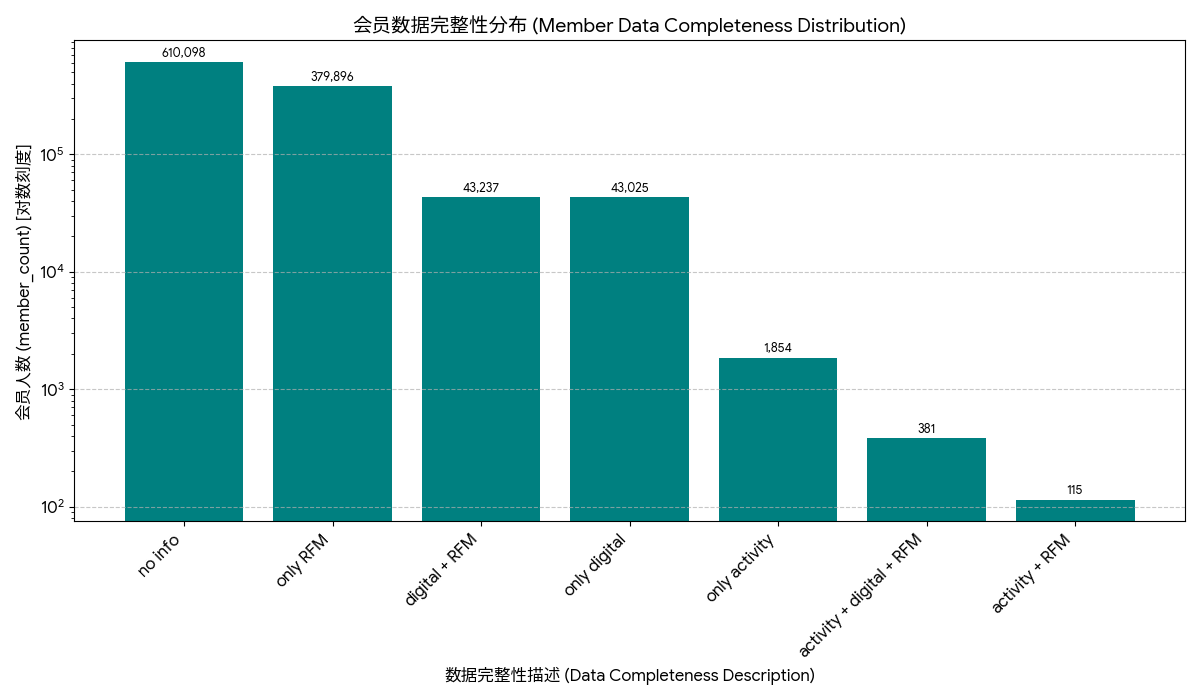

## ================ NORMALIZATION ==================

In [322]:
final_df_imputed = final_df.copy()

# ============= Missing value impute =============
all_features = [col for col in final_df_imputed.columns if any(keyword in col for keyword in ['R_', 'F_', 'M_', 'PDP_', 'ATC_', 'activity_'])]

for col in all_features:
    if col.startswith('R_') or col.startswith('PDP_View_Days_Since_') or col.startswith('ATC_Days_Since_'):
        # 填充 Recency (R) 为9999
        final_df_imputed[col].fillna(9999, inplace=True)
    else:
        # 填充 F, M, Ratio, PDP, ATC, Activity 等为 0 (假设缺失即为0次/0金额)
        final_df_imputed[col].fillna(0, inplace=True)
        
final_df_imputed.head(5)

/tmp/ipykernel_608/474617980.py:12: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_608/474617980.py:9: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df

,member_uid,PDP_View_6M_Count_allday,PDP_View_6M_Count_outdoor,PDP_View_6M_Count_running,PDP_View_6M_Count_tennis,PDP_View_6M_Count_training,PDP_View_Days_Since_Last_allday,PDP_View_Days_Since_Last_outdoor,PDP_View_Days_Since_Last_running,PDP_View_Days_Since_Last_tennis,PDP_View_Days_Since_Last_training,ATC_6M_Count_allday,ATC_6M_Count_outdoor,ATC_6M_Count_running,ATC_6M_Count_tennis,ATC_6M_Count_training,ATC_Days_Since_Last_allday,ATC_Days_Since_Last_outdoor,ATC_Days_Since_Last_running,ATC_Days_Since_Last_tennis,ATC_Days_Since_Last_training,activity_count_allday,activity_count_outdoor,activity_count_running,activity_count_tennis,activity_count_training,R_running,R_tennis,R_allday,R_training,R_outdoor,F_4m_running,F_4m_tennis,F_4m_allday,F_4m_training,F_4m_outdoor,M_4m_running,M_4m_tennis,M_4m_allday,M_4m_training,M_4m_outdoor,F_1y_running,F_1y_tennis,F_1y_allday,F_1y_training,F_1y_outdoor,M_1y_running,M_1y_tennis,M_1y_allday,M_1y_training,M_1y_outdoor
2,14749aac-e36a-4477-bfa1-fede3b3c3fe4,0.0,0.0,0.0,0.0,0.0,9999.0,9999.0,9999.0,9999.0,9999.0,0.0,0.0,0.0,0.0,0.0,9999.0,9999.0,9999.0,9999.0,9999.0,0.0,0.0,0.0,0.0,0.0,684.0,9999.0,684.0,9999.0,9999.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,793d6c2d-2230-4e64-8287-176a78e0a8bd,1866.0,212.0,4320.0,400.0,472.0,2.0,5.0,5.0,30.0,24.0,166.0,104.0,373.0,0.0,47.0,84.0,107.0,5.0,9999.0,45.0,0.0,0.0,0.0,0.0,0.0,32.0,9999.0,86.0,232.0,196.0,10.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.0,0.0,5.0,2.0,2.0,1490.0,0.0,220.0,0.0,0.0
5,142a2891-6887-4066-8844-4afcc2d551df,0.0,0.0,0.0,0.0,0.0,9999.0,9999.0,9999.0,9999.0,9999.0,0.0,0.0,0.0,0.0,0.0,9999.0,9999.0,9999.0,9999.0,9999.0,0.0,0.0,0.0,0.0,0.0,9999.0,9999.0,104.0,9999.0,9999.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1290.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1290.0,0.0,0.0
7,ce47f1ba-04b9-4733-a43e-ede1fb9a007d,0.0,0.0,0.0,0.0,0.0,9999.0,9999.0,9999.0,9999.0,9999.0,0.0,0.0,0.0,0.0,0.0,9999.0,9999.0,9999.0,9999.0,9999.0,0.0,0.0,0.0,0.0,0.0,815.0,9999.0,9999.0,9999.0,9999.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,55dca87a-48fb-4844-a891-a9d1b38c265e,0.0,0.0,0.0,0.0,0.0,9999.0,9999.0,9999.0,9999.0,9999.0,0.0,0.0,0.0,0.0,0.0,9999.0,9999.0,9999.0,9999.0,9999.0,0.0,0.0,0.0,0.0,0.0,9999.0,9999.0,9999.0,9999.0,751.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [323]:
# 初始化所需的缩放器
min_max_scaler = MinMaxScaler()
robust_scaler = RobustScaler()

df_normalized = final_df_imputed.copy()

# --- 1. 处理 Recency (R) 类特征：使用 RobustScaler ---

recency_cols = [col for col in all_features if col.startswith('R_') or col.startswith('PDP_View_Days_Since_') or col.startswith('ATC_Days_Since_')]

for col in recency_cols:
    # 1.1 使用 RobustScaler 进行缩放（对极值鲁棒）
    # RobustScaler 结果范围不固定，但能减轻极值影响
    df_normalized[col + '_robust'] = robust_scaler.fit_transform(final_df_imputed[[col]])
    
    # 1.2 对 RobustScaler 的结果进行 MinMax 缩放，强制到 0-1 范围
    # 确保得分在 0-1 之间，同时保留 RobustScaler 对极值的鲁棒性
    df_normalized[col + '_norm'] = min_max_scaler.fit_transform(df_normalized[[col + '_robust']])
    
    # 1.3 反转得分 (值越小，得分越接近 1)
    df_normalized[col + '_score'] = 1 - df_normalized[col + '_norm']
    
    df_normalized.drop(columns=[col + '_norm'], inplace=True)
    df_normalized.drop(columns=[col + '_robust'], inplace=True)


# --- 2. 处理 Positive (F/M/Count) 类特征：使用 Log + MinMax ---

positive_cols = [col for col in all_features if col not in recency_cols]

for col in positive_cols:
    # 2.1 对特征进行对数变换 (np.log1p = log(1+x))，压缩大值
    # 确保特征值非负，并假设 0 填充是正确的
    df_normalized[col + '_log'] = np.log1p(final_df_imputed[[col]])
    
    # 2.2 使用 MinMaxScaler 进行标准化 (值越大，得分越接近 1)
    df_normalized[col + '_score'] = min_max_scaler.fit_transform(df_normalized[[col + '_log']])

    # 清理中间列 (可选)
    df_normalized.drop(columns=[col + '_log'], inplace=True)
    
    
print("--- 特征标准化完成 ---")
df_normalized.head(5)

--- 特征标准化完成 ---


,member_uid,PDP_View_6M_Count_allday,PDP_View_6M_Count_outdoor,PDP_View_6M_Count_running,PDP_View_6M_Count_tennis,PDP_View_6M_Count_training,PDP_View_Days_Since_Last_allday,PDP_View_Days_Since_Last_outdoor,PDP_View_Days_Since_Last_running,PDP_View_Days_Since_Last_tennis,PDP_View_Days_Since_Last_training,ATC_6M_Count_allday,ATC_6M_Count_outdoor,ATC_6M_Count_running,ATC_6M_Count_tennis,ATC_6M_Count_training,ATC_Days_Since_Last_allday,ATC_Days_Since_Last_outdoor,ATC_Days_Since_Last_running,ATC_Days_Since_Last_tennis,ATC_Days_Since_Last_training,activity_count_allday,activity_count_outdoor,activity_count_running,activity_count_tennis,activity_count_training,R_running,R_tennis,R_allday,R_training,R_outdoor,F_4m_running,F_4m_tennis,F_4m_allday,F_4m_training,F_4m_outdoor,M_4m_running,M_4m_tennis,M_4m_allday,M_4m_training,M_4m_outdoor,F_1y_running,F_1y_tennis,F_1y_allday,F_1y_training,F_1y_outdoor,M_1y_running,M_1y_tennis,M_1y_allday,M_1y_training,M_1y_outdoor,PDP_View_Days_Since_Last_allday_score,PDP_View_Days_Since_Last_outdoor_score,PDP_View_Days_Since_Last_running_score,PDP_View_Days_Since_Last_tennis_score,PDP_View_Days_Since_Last_training_score,ATC_Days_Since_Last_allday_score,ATC_Days_Since_Last_outdoor_score,ATC_Days_Since_Last_running_score,ATC_Days_Since_Last_tennis_score,ATC_Days_Since_Last_training_score,R_running_score,R_tennis_score,R_allday_score,R_training_score,R_outdoor_score,PDP_View_6M_Count_allday_score,PDP_View_6M_Count_outdoor_score,PDP_View_6M_Count_running_score,PDP_View_6M_Count_tennis_score,PDP_View_6M_Count_training_score,ATC_6M_Count_allday_score,ATC_6M_Count_outdoor_score,ATC_6M_Count_running_score,ATC_6M_Count_tennis_score,ATC_6M_Count_training_score,activity_count_allday_score,activity_count_outdoor_score,activity_count_running_score,activity_count_tennis_score,activity_count_training_score,F_4m_running_score,F_4m_tennis_score,F_4m_allday_score,F_4m_training_score,F_4m_outdoor_score,M_4m_running_score,M_4m_tennis_score,M_4m_allday_score,M_4m_training_score,M_4m_outdoor_score,F_1y_running_score,F_1y_tennis_score,F_1y_allday_score,F_1y_training_score,F_1y_outdoor_score,M_1y_running_score,M_1y_tennis_score,M_1y_allday_score,M_1y_training_score,M_1y_outdoor_score
2,14749aac-e36a-4477-bfa1-fede3b3c3fe4,0.0,0.0,0.0,0.0,0.0,9999.0,9999.0,9999.0,9999.0,9999.0,0.0,0.0,0.0,0.0,0.0,9999.0,9999.0,9999.0,9999.0,9999.0,0.0,0.0,0.0,0.0,0.0,684.0,9999.0,684.0,9999.0,9999.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.000,0.0000,0.000000,0.000000,0.0000,0.0,0.0000,0.931686,0.0,0.931686,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.000000,0.00000,0.000000,0.000000,0.0,0.000000,0.0,0.0
3,793d6c2d-2230-4e64-8287-176a78e0a8bd,1866.0,212.0,4320.0,400.0,472.0,2.0,5.0,5.0,30.0,24.0,166.0,104.0,373.0,0.0,47.0,84.0,107.0,5.0,9999.0,45.0,0.0,0.0,0.0,0.0,0.0,32.0,9999.0,86.0,232.0,196.0,10.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.0,0.0,5.0,2.0,2.0,1490.0,0.0,220.0,0.0,0.0,0.9998,0.9995,0.9995,0.997,0.9976,0.991599,0.989299,0.9995,0.0,0.9955,0.996899,0.0,0.991498,0.976895,0.980496,0.657208,0.615699,0.753677,0.52408,0.671548,0.547414,0.674219,0.721341,0.0,0.523656,0.0,0.0,0.0,0.0,0.0,0.460294,0.0,0.169861,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.51379,0.0,0.259421,0.26222,0.231534,0.635557,0.0,0.419470,0.0,0.0
5,142a2891-6887-4066-8844-4afcc2d551df,0.0,0.0,0.0,0.0,0.0,9999.0,9999.0,9999.0,9999.0,9999.0,0.0,0.0,0.0,0.0,0.0,9999.0,9999.0,9999.0,9999.0,9999.0,0.0,0.0,0.0,0.0,0.0,9999.0,9999.0,104.0,9999.0,9999.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1290.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1290.0,0.0,0.0,0.0000,0.0000,0.0000,0.000,0.0000,0.000000,0.000000,0.0000,0.0,0.0000,0.000000,0.0,0.989698,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.107171,0.0,0.0,0.0,0.

# ========================= SCORING =========================

In [324]:
# --- 0. 定义目标品类和抽象权重 ---

# 目标品类列表
target_verticals = ['tennis', 'running', 'outdoor', 'training', 'allday']

# 抽象特征权重模板 (不包含任何品类名)
dimension_weights_template_abstract = {
    # 抽象特征名 : 权重
    'R': 0.1,
    'F_4m': 0.2,
    'F_1y': 0.1,
    'M_4m': 0.2,
    'M_1y': 0.15,
    'PDP_View_6M_Count': 0.05,
    'PDP_View_Days_Since_Last': 0.05,
    'ATC_6M_Count': 0.05,
    'ATC_Days_Since_Last': 0.05,
    'activity_count': 0.05,
}

# 确保权重总和已知
BASE_WEIGHT_SUM = sum(dimension_weights_template_abstract.values())
if BASE_WEIGHT_SUM != 1:
     print(f"⚠️ 警告：基础权重总和为 {BASE_WEIGHT_SUM:.2f} (非 1.0)。最终得分范围将受此影响。")



⚠️ 警告：基础权重总和为 1.00 (非 1.0)。最终得分范围将受此影响。


In [325]:
# ----------------------------------------------------------------------
# 1. 定义打分函数
# ----------------------------------------------------------------------

def calculate_affinity_score(df, vertical_name, abstract_weights):
    """
    根据抽象权重模板和品类名称，计算该品类的 Affinity Score。
    """
    
    score_column_name = f'Affinity_Score_{vertical_name}'
    current_weights = {}

    # 动态生成当前品类的特征分数列名
    for abstract_feature_key, weight in abstract_weights.items():
        
        # 核心步骤：构建实际的得分列名
        # 例如: 'R' 结合 'run' -> 'R_run_score'
        # 例如: 'F_4m' 结合 'outdoor' -> 'F_4m_outdoor_score'
        # 我们假设您的标准化列名格式是 [抽象特征]_[品类名]_score
        
        # 确定新列名：在抽象特征名后面加上品类名和 '_score'
        new_feature_score_name = f'{abstract_feature_key}_{vertical_name}_score'
        
        # 检查新列名是否存在于 DataFrame 中
        if new_feature_score_name in df.columns:
            current_weights[new_feature_score_name] = weight
        else:
            print(f"⚠️ 警告：品类 {vertical_name} 缺少特征列: {new_feature_score_name}，已跳过。")


    # 2. 计算加权总分
    df[score_column_name] = 0.0

    # 累加： 特征得分 * 权重
    for feature_score_col, weight in current_weights.items():
        df[score_column_name] += df[feature_score_col] * weight

    return df


In [326]:

# ----------------------------------------------------------------------
# 2. 循环计算所有品类得分
# ----------------------------------------------------------------------

df_scored = df_normalized.copy() 
scored_columns = []

for v_name in target_verticals:
    df_scored = calculate_affinity_score(df_scored, v_name, dimension_weights_template_abstract)
    score_col = f'Affinity_Score_{v_name}'
    scored_columns.append(score_col)



In [327]:

# ----------------------------------------------------------------------
# 3. 结果展示
# ----------------------------------------------------------------------

print("\n--- ✅ 所有目标品类 Affinity Score 计算完成 (抽象模板) ---")

# 展示所有新生成的 Affinity Score 列 (以及 member_uid)
print(df_scored[['member_uid'] + scored_columns].head())


--- ✅ 所有目标品类 Affinity Score 计算完成 (抽象模板) ---
                              member_uid  Affinity_Score_tennis  Affinity_Score_running  Affinity_Score_outdoor  Affinity_Score_training  Affinity_Score_allday
2   14749aac-e36a-4477-bfa1-fede3b3c3fe4               0.000000                0.093169                0.000000                 0.000000               0.093169
3   793d6c2d-2230-4e64-8287-176a78e0a8bd               0.076054                0.512162                0.285139                 0.283327               0.381786
5   142a2891-6887-4066-8844-4afcc2d551df               0.000000                0.000000                0.000000                 0.000000               0.332446
7   ce47f1ba-04b9-4733-a43e-ede1fb9a007d               0.000000                0.091858                0.000000                 0.000000               0.000000
10  55dca87a-48fb-4844-a891-a9d1b38c265e               0.000000                0.000000                0.092498                 0.000000               0.00

# ========================= OUTPUT ANALYSIS ==========================

In [328]:
# df_scored[['member_uid'] + scored_columns].describe()
df_scored[['member_uid'] + scored_columns].describe()

,Affinity_Score_tennis,Affinity_Score_running,Affinity_Score_outdoor,Affinity_Score_training,Affinity_Score_allday
count,468933.000000,468933.000000,468933.000000,468933.000000,468933.000000
mean,0.021712,0.105268,0.031477,0.040346,0.097228
std,0.071754,0.127982,0.082954,0.097321,0.122722
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.074708,0.000000,0.000000,0.061624
75%,0.000000,0.201585,0.000000,0.000000,0.187924
max,0.904191,0.902222,0.851905,0.868980,0.889482


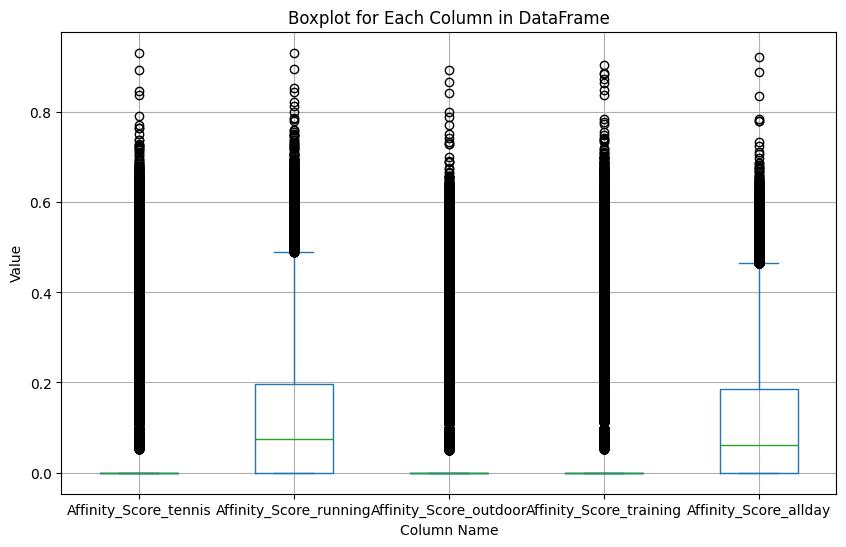

In [307]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6)) # 设置图的大小
df_scored[scored_columns].plot.box(
    title='Boxplot for Each Column in DataFrame',
    grid=True,
    vert=True, # 垂直箱线图
    ax=plt.gca() # 使用当前的 Matplotlib Axes
)

plt.xlabel("Column Name")
plt.ylabel("Value")
plt.show()

In [333]:
df_scored[['member_uid']+ [col for col in df_scored.columns if any(keyword in col for keyword in ['tennis'])]].sort_values(by='Affinity_Score_tennis',ascending=False).head(10)

,member_uid,PDP_View_6M_Count_tennis,PDP_View_Days_Since_Last_tennis,ATC_6M_Count_tennis,ATC_Days_Since_Last_tennis,activity_count_tennis,R_tennis,F_4m_tennis,M_4m_tennis,F_1y_tennis,M_1y_tennis,PDP_View_Days_Since_Last_tennis_score,ATC_Days_Since_Last_tennis_score,R_tennis_score,PDP_View_6M_Count_tennis_score,ATC_6M_Count_tennis_score,activity_count_tennis_score,F_4m_tennis_score,M_4m_tennis_score,F_1y_tennis_score,M_1y_tennis_score,Affinity_Score_tennis
64498,9039690e-5c61-45ee-a2cc-38cce7d6d3ee,5901.0,3.0,1212.0,42.0,0.0,25.0,164.0,19190.0,264.0,40580.0,0.999700,0.995800,0.997600,0.759199,0.872839,0.0,1.000000,0.910127,1.000000,0.940193,0.904191
30180,1fc88076-c081-472b-a513-3f4258419634,9119.0,0.0,528.0,63.0,0.0,4.0,91.0,24800.0,230.0,71896.0,1.000000,0.993699,0.999700,0.797249,0.770832,0.0,0.885593,0.933793,0.975391,0.990869,0.888106
389546,b85a94e3-2b50-4ac2-bbbf-f4dafc06c6f7,18028.0,2.0,1194.0,104.0,0.0,58.0,49.0,26090.0,121.0,79700.0,0.999800,0.989599,0.994299,0.856837,0.871002,0.0,0.766170,0.938472,0.860977,1.000000,0.862318
250834,cb51354c-46ef-43ae-afe8-18d59e8fa95c,8770.0,1.0,785.0,3.0,0.0,2.0,44.0,19549.0,95.0,44204.0,0.999900,0.999700,0.999900,0.793837,0.819505,0.0,0.745535,0.911838,0.818023,0.947772,0.836080
64363,abea2095-6881-4646-86ca-7f5d76a071a6,395.0,36.0,888.0,2.0,0.0,5.0,32.0,13880.0,63.0,19810.0,0.996400,0.999800,0.999600,0.522983,0.834641,0.0,0.684791,0.880234,0.745356,0.876658,0.786691
11859,50bfa322-8a4a-4819-9aed-ee7f7f477f3b,5931.0,33.0,239.0,97.0,0.0,29.0,27.0,16040.0,37.0,23570.0,0.996700,0.990299,0.997199,0.759642,0.673682,0.0,0.652613,0.893581,0.651929,0.892056,0.778976
210949,00fbb774-fe0c-4fcf-bc8e-3137b53bd151,348.0,2.0,1056.0,2.0,0.0,31.0,23.0,9110.0,66.0,27140.0,0.999800,0.999800,0.996999,0.511936,0.855918,0.0,0.622422,0.841379,0.753566,0.904551,0.771872
115158,42114514-6f37-44d6-a204-93fc20ec2ca1,13452.0,0.0,536.0,40.0,0.0,45.0,27.0,8690.0,36.0,14470.0,1.000000,0.996000,0.995599,0.831238,0.772677,0.0,0.652613,0.837024,0.647149,0.848828,0.769522
204211,04b50d50-8588-40a7-8aa2-8ed5f7b85cfd,54045.0,0.0,433.0,47.0,0.0,6.0,25.0,8970.0,25.0,8970.0,1.000000,0.995300,0.999500,0.952827,0.746501,0.0,0.638099,0.839950,0.583917,0.806461,0.759652
408075,b4a66ab8-84fa-4ff2-a0b0-f5e38c30729e,11949.0,53.0,944.0,101.0,0.0,104.0,13.0,8770.0,31.0,21190.0,0.994699,0.989899,0.989698,0.820879,0.842150,0.0,0.516860,0.837869,0.621130,0.882624,0.746804


In [309]:
df_scored.shape

(468933, 106)

In [ ]:
df_scored.head(5)

# ========================= WRITE TO MYSQL ==========================

In [334]:
try:
    # 4. 使用 to_sql() 写入数据
    TABLE_NAME = 'ds_temp_vertical_affinity_1125' # 你想在 MySQL 中创建的表名

    df_scored.to_sql(
        name=TABLE_NAME,      # 表名
        con=engine,           # 数据库连接引擎
        if_exists='replace',  # 如果表已存在：'fail', 'replace' (替换), 或 'append' (追加)
        index=False,          # 不将 DataFrame 的 index 写入数据库作为一列
        chunksize=1000        # 可选：分块写入，对大型数据集很有用
    )
    
    print(f"\nDataFrame 已成功写入 MySQL 数据库表: {TABLE_NAME}")

except Exception as e:
    print(f"\n写入数据库失败，请检查连接信息和依赖库是否正确。错误信息: {e}")


DataFrame 已成功写入 MySQL 数据库表: ds_temp_vertical_affinity_1125
